# State of Health Analysis on Pulsed Load Period

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from mat4py import loadmat
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [4]:
data = loadmat('RW9.mat')

In [5]:
#Pulling out all the data from raw dataset

data2=data['data']

step=data2['step']

In [6]:
#Eight features
comment=pd.Series(step['comment'])
Type=pd.Series(step['type'])
current=pd.Series(step['current'])
time=pd.Series(step['time'])
relativeTime=pd.Series(step['relativeTime'])
voltage=pd.Series(step['voltage'])
temperature=pd.Series(step['temperature'])
date=pd.Series(step['date'])
#This df is our whole Dataframe
df=pd.DataFrame([comment,Type,date,current,time,relativeTime,voltage,temperature])
df=df.T
df.columns=['comment','Type','date','current','time','relativeTime','voltage','temperature']
#%%There are 15 different comment types 
comment_type = []
for i in comment:
    comment_type.append(i)
comment_type = set(comment_type)
comment_type=list(comment_type)

# Pulling Out Data for Pulsed Load period 

In [7]:
#pulling out data for the second period - pulsed period (pulse load(discharge) + pulse load(rest) )   

 #Type: Pulsed Load(PL) 
 #Pulling out all the data related to the PL
df_PL = np.array(df[(df['comment'] == 'pulsed load (discharge)') | (df['comment'] == 'pulsed load (rest)') ])
df_PL=pd.DataFrame(df_PL)
df_PL.columns=['comment','Type','date','current','time','relativeTime','voltage','temperature']


size_PL=[]
for i in range(len(df_PL)):
    size_PL.append(len(df_PL['relativeTime'][i]))
df_PL

#%Pulling out all observations of each cycle of Pulsed Load

all_comment = list()
all_Type = list()
all_date = list()

all_Type = [df_PL['Type'][j]  for j in range(len(df_PL)) for _ in range(len(df_PL['voltage'][j])) ]
all_comment = [df_PL['comment'][j]  for j in range(len(df_PL)) for _ in range(len(df_PL['voltage'][j])) ]
all_date = [df_PL['date'][j]  for j in range(len(df_PL)) for _ in range(len(df_PL['voltage'][j])) ]
#all_comment.append(df2['comment'][i])

#columns we need to pull out for each list in each row i for i in range(len(df)):
all_current = list()
all_time = list()
all_relativetime = list()
all_voltage = list()
all_temperature = list()


for i in range(len(df_PL)):
    for j in range(len(df_PL['current'][i])):
        
        all_current.append(df_PL['current'][i][j])
        all_time.append(df_PL['time'][i][j])
        all_relativetime.append(df_PL['relativeTime'][i][j])
        all_temperature.append(df_PL['temperature'][i][j])
        #all_Type.append(df2['Type'][i])
        #all_date.append(df2['date'][i])
        all_voltage.append(df_PL['voltage'][i][j])
        #all_comment.append(df2['comment'][i])
        
pulsed_load_ds = np.transpose(np.array([all_comment,all_Type,all_date, all_current,all_time, all_relativetime,all_voltage, all_temperature ]))

pulsed_load_df = pd.DataFrame(pulsed_load_ds)

pulsed_load_df.columns = ['comment','Type','date','current','time','relativeTime','voltage','temperature']

pulsed_load_df  #It's related to all the cycles of the 'refrence discharge' by pulling out all observations respect to the second for each row

,comment,Type,date,current,time,relativeTime,voltage,temperature
0,pulsed load (rest),R,07-Jan-2014 02:37:40,0,46858.079999999994,0.01,4.199,22.99587
1,pulsed load (rest),R,07-Jan-2014 02:37:40,0,46859.079999999994,1.01,4.199,22.98026
2,pulsed load (rest),R,07-Jan-2014 02:37:40,0,46860.08,2.01,4.199,22.98026
3,pulsed load (rest),R,07-Jan-2014 02:37:40,0,46861.08,3.01,4.199,22.98026
4,pulsed load (rest),R,07-Jan-2014 02:37:40,0,46862.08,4.01,4.199,22.98026
...,...,...,...,...,...,...,...,...
326302,pulsed load (discharge),D,31-May-2014 00:09:29,1.0,12496717.25,244.04,3.205,34.45753
326303,pulsed load (discharge),D,31-May-2014 00:09:29,1.0,12496718.25,245.04,3.204,34.47299
326304,pulsed load (discharge),D,31-May-2014 00:09:29,1.001,12496719.25,246.04,3.203,34.47299
326305,pulsed load (discharge),D,31-May-2014 00:09:29,1.0,12496720.25,247.04,3.201,34.47299


# Average Some Features for Pulsed Load Period

In [8]:
from statistics import mean
df_PL['current_avg'] = df_PL['current'].map(mean)
df_PL['time_avg'] = df_PL['time'].map(mean)              
df_PL['relativeTime_avg'] = df_PL['relativeTime'].map(mean)              
df_PL['voltage_avg'] = df_PL['voltage'].map(mean)              
df_PL['temperature_avg'] = df_PL['temperature'].map(mean)              


# Features

In [9]:
# discharging time
df_PL['duration'] = 0
for i in range(0,len(df_PL)):
    df_PL['duration'][i] = max(df_PL['relativeTime'][i]) - min(df_PL['relativeTime'][i])



<ipython-input-9-6b4e43e9c266>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PL['duration'][i] = max(df_PL['relativeTime'][i]) - min(df_PL['relativeTime'][i])


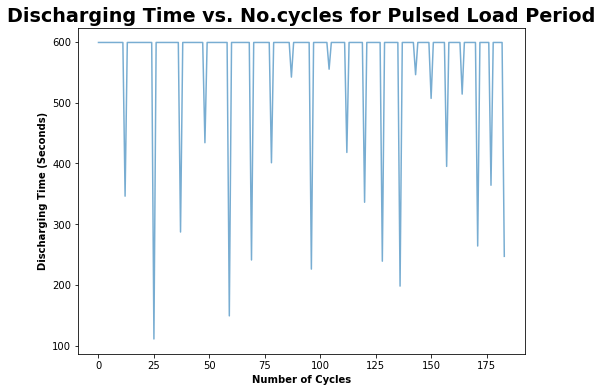

"\n# ploting duration rate against number of cycles\ninitial = max(duration)\nduration_rate = list(map(lambda x: x / initial, duration))\nplt.plot(duration_rate)\nplt.title('duration rate vs. cycle times')\nplt.show()\n"

In [10]:
# ploting discharing time against number of cycles

duration = df_PL['duration'].copy()
duration = [i for i in duration if i != 1199]

plt.figure(figsize=(8, 6)) 

plt.plot(duration, alpha
         = 0.6)

#plt.text(-10, -60, 'https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/\nBrian Bole, Chetan Kulkarni, and Matthew Daigle, \n“Adaptation of an Electrochemistry-based Li-Ion Battery Model to Account for Deterioration Observed Under Randomized Use”, \nin the proceedings of the Annual Conference of the Prognostics and Health Management Society, 2014',fontsize=7)   
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharging Time (Seconds)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharging Time vs. No.cycles for Pulsed Load Period',weight='bold')


plt.show()


## Internal Resistence 

In [11]:
# internal resistence avg

df_PL['internal_resistence_avg'] = pd.Series() 
for i in range(0,368,2):
    df_PL['internal_resistence_avg'][i] = (df_PL['voltage_avg'][i] - df_PL['voltage_avg'][i+1])/df_PL['current_avg'][i+1]
  



<ipython-input-11-6652949b3b55>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_PL['internal_resistence_avg'] = pd.Series()
<ipython-input-11-6652949b3b55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PL['internal_resistence_avg'][i] = (df_PL['voltage_avg'][i] - df_PL['voltage_avg'][i+1])/df_PL['current_avg'][i+1]


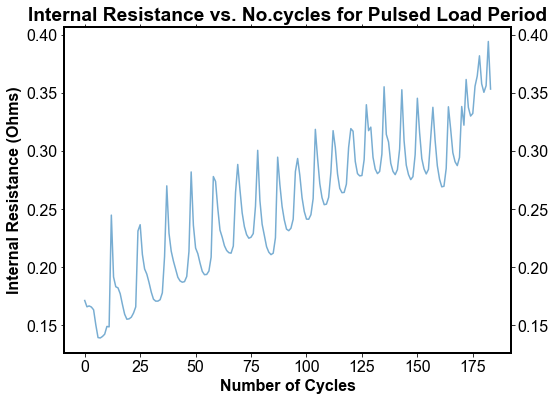

In [29]:
# plot internal resistance against cycles 
r = df_PL['internal_resistence_avg'].replace(-np.inf, np.nan, regex=True).dropna()
r = r.reset_index(drop = True)

plt.figure(figsize=(8, 6)) 

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.plot(r.index,r,alpha = 0.6)

plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Internal Resistance (Ohms)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Internal Resistance vs. No.cycles for Pulsed Load Period',weight='bold')
plt.show()



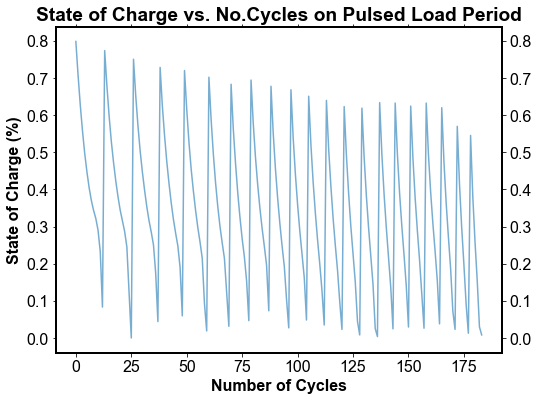

In [13]:
# state of charge voltage-based on load period

# state of charge voltage based
df_PL['soc'] = (df_PL['voltage_avg'] - min(df_PL['voltage_avg']))/(max(df_PL['voltage_avg']) - min(df_PL['voltage_avg']))
# extract soc for only load phase
soc = []
for i in range(1,368,2):
    soc.append(df_PL['soc'][i])

plt.figure(figsize=(8, 6)) 

plt.plot( soc, alpha = 0.6)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('State of Charge (%)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('State of Charge vs. No.Cycles on Pulsed Load Period',weight='bold')
plt.show()

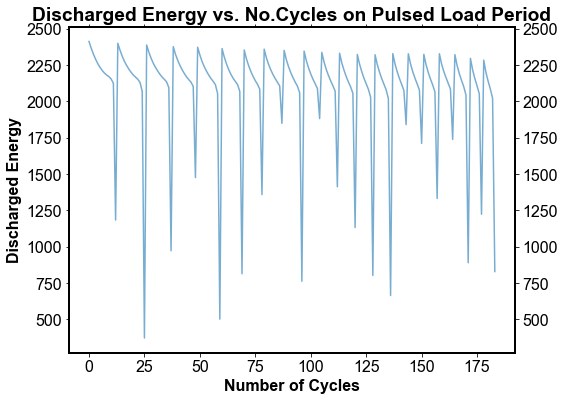

In [14]:
# discharge energy 
discharge_energy = list()
for i in range(1,368, 2):
    q =  (df_PL['current_avg'][i] * df_PL['duration'][i] * df_PL['voltage_avg'][i])
    discharge_energy.append(q)
    
plt.figure(figsize=(8, 6)) 

plt.plot( discharge_energy, alpha = 0.6)
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharged Energy',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharged Energy vs. No.Cycles on Pulsed Load Period',weight='bold')
plt.show()


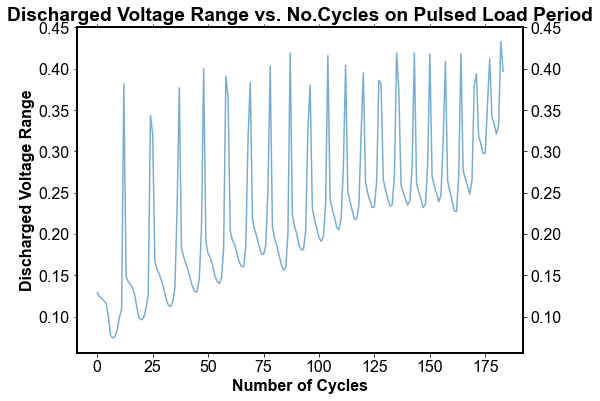

In [15]:

# discharge voltage range
discharge_range = list()
for i in range(1,368, 2):
    q =  (max(df_PL['voltage'][i]) - min(df_PL['voltage'][i]))
    discharge_range.append(q)
    
plt.figure(figsize=(8, 6)) 

plt.plot( discharge_range, alpha = 0.6)
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Discharged Voltage Range',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Discharged Voltage Range vs. No.Cycles on Pulsed Load Period',weight='bold')
plt.show()

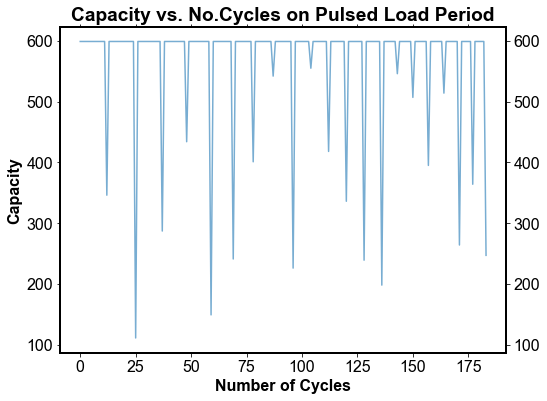

In [16]:
# capacity on Pulsed Load Period
capacity = []
for i in range(1,368,2):
    
    cap = (df_PL['current_avg'][i] *  df_PL['duration'][i] )
    capacity.append(cap)
plt.figure(figsize=(8, 6)) 

plt.plot( capacity, alpha = 0.6)
plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Capacity',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Capacity vs. No.Cycles on Pulsed Load Period',weight='bold')
plt.show()

# Define Failure Threshold

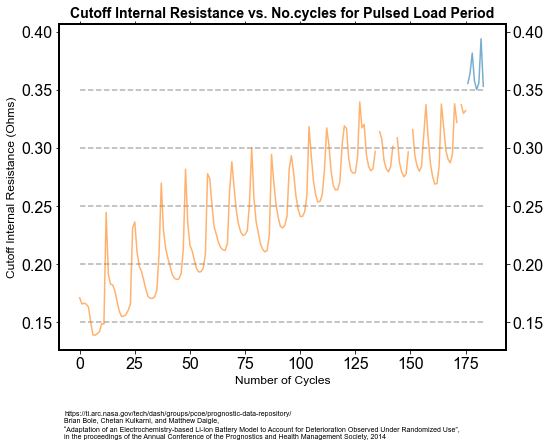

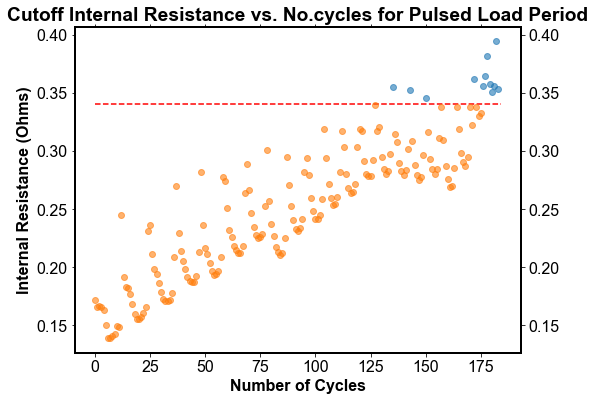

In [17]:
# define failure threshold


cutoff = 2 * r[0]

unhealthy = np.ma.masked_where(r > cutoff, r)
healthy = np.ma.masked_where(r <= cutoff, r)

# plot internal resistance against cycles 
plt.figure(figsize=(8, 6)) 

plt.plot(r.index,healthy,r.index,unhealthy, alpha = 0.6)
plt.ylabel('Cutoff Internal Resistance (Ohms)',fontsize = 12)
plt.xlabel('Number of Cycles',fontsize = 12)
plt.title('Cutoff Internal Resistance vs. No.cycles for Pulsed Load Period', c = 'black',fontsize = 14,weight='bold')
plt.hlines(np.arange(0.15,0.40,0.05),0,184,colors='black', alpha = 0.3, linestyles='dashed',)

plt.text(-7,0.05, 'https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/\nBrian Bole, Chetan Kulkarni, and Matthew Daigle, \n“Adaptation of an Electrochemistry-based Li-Ion Battery Model to Account for Deterioration Observed Under Randomized Use”, \nin the proceedings of the Annual Conference of the Prognostics and Health Management Society, 2014',fontsize=7)   
plt.show()


# scatter plot

plt.figure(figsize=(8, 6)) 

plt.plot(r.index,healthy,'o', r.index,unhealthy,'o', alpha = 0.6)

plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Internal Resistance (Ohms)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.hlines(0.34,0,184,colors='red', linestyles='dashed')

plt.title('Cutoff Internal Resistance vs. No.cycles for Pulsed Load Period',weight='bold')
plt.show()


In [18]:
# find the cutoff cycle, the nearest cycle of the cutoff internal resistance
cutoff_cycle = (np.abs(r-cutoff)).argmin()
print('cutoff cycle is No.', cutoff_cycle)

cutoff cycle is No. 150


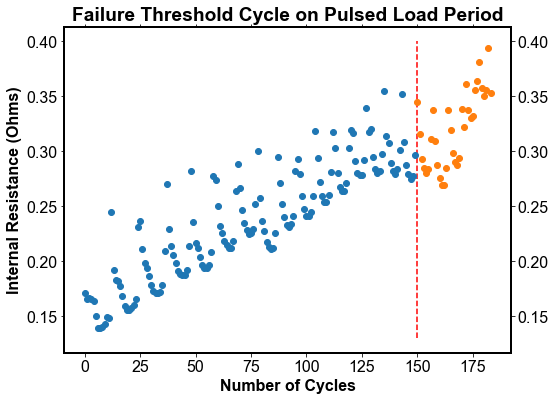

In [19]:
# plot failure based on cutoff cycle

plt.figure(figsize=(8, 6)) 

plt.plot(r[0:150].index,r[0:150],'o',r[150:184].index,r[150:184],'o')
plt.vlines(150, 0.13, 0.4, colors='red',linestyles='dashed')


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Internal Resistance (Ohms)',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Failure Threshold Cycle on Pulsed Load Period',weight='bold')
plt.show()


# Cycle Estimation

## Prepare Estimation Dataframe

In [30]:
# State of Health dataframe
# soh
# soc
# discharge_energy
c = list()
v_ocv = list()
v_bat = list()
cycle = np.arange(1,185)
d = list()
t = list()
for i in range(0,368,2):
    c.append(df_PL['current_avg'][i+1])
    v_ocv.append(df_PL['voltage_avg'][i])
    v_bat.append(df_PL['voltage_avg'][i+1])
    d.append(df_PL['duration'][i+1])
    t.append(df_PL['temperature_avg'][i+1])

features = ['current','voltage_ocv','voltage_bat','internal_resistance','duration','temperature','soc','discharge_energy','discharge_range','capacity']
soh_df = pd.DataFrame([c,v_ocv,v_bat,r,d,t,soc,discharge_energy,discharge_range,capacity,cycle])
soh_df = np.transpose(soh_df)
soh_df.columns = ['current','voltage_ocv','voltage_bat','internal_resistance','duration','temperature','soc','discharge_energy','discharge_range','capacity','cycle']

np.random.seed(1)
threshold = np.random.rand(len(soh_df)) < 0.8
train = soh_df[threshold]
test = soh_df[~threshold]

X = train[features].astype(float)
Y = train['cycle'].astype(float)

X_test = test[features].astype(float)
Y_test = test['cycle'].astype(float) 


In [22]:
# select features
def minAIC_OLS(X,Y):
    variables = X.columns
    model = sm.OLS(Y,X[variables]).fit()
    while True:
        print(f'old model AIC：{model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        removed = variables[model.pvalues == maxp].values
        print(f'consider a model with these variables removed:{removed}')
        newmodel = sm.OLS(Y,X[newvariables]).fit()
        print(f'new model AIC :{newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model, variables

## Variables Selection

In [23]:
model_new, features_new = minAIC_OLS(X,Y)
model_new.summary()
print(features_new)

old model AIC：1122.7969451129738
consider a model with these variables removed:['voltage_bat']
new model AIC :1120.9157904307026
old model AIC：1120.9157904307026
consider a model with these variables removed:['discharge_energy']
new model AIC :1119.0394448926832
old model AIC：1119.0394448926832
consider a model with these variables removed:['duration']
new model AIC :1117.3624344708387
old model AIC：1117.3624344708387
consider a model with these variables removed:['capacity']
new model AIC :1115.7186893990774
old model AIC：1115.7186893990774
consider a model with these variables removed:['soc']
new model AIC :1119.4013144372302
Index(['current', 'voltage_ocv', 'internal_resistance', 'temperature', 'soc',
       'discharge_range'],
      dtype='object')


## Random Forest

In [24]:
from statistics import mean
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score


In [26]:
depth = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracy = list()
accuracy_modified = list()
mse = []
r2 = []
for d in depth:
    clf = DecisionTreeRegressor(random_state=0, criterion = "mse", splitter = "best", max_depth = d)
    model = clf.fit(X[features_new], Y) # Use the training data to build 
    y_test_pred = np.round(model.predict(X_test[features_new]))
    m = mean_squared_error(Y_test, y_test_pred)
    rscore = r2_score(Y_test, y_test_pred)

    mse.append(m)
    r2.append(rscore)
    print('depth:' ,d)
    print ("Test MSE Pulsed Load ", m)
    print ("R2 Pulsed Load ", rscore)

    y_pred = model.predict(soh_df[features_new].astype(float))
    y_pred = np.round(y_pred)

    soh_df['predict'] = y_pred
    
# Accuracy Calculation
    correct = 0
    actual = list()
    pred = list()
    for i in range(len(soh_df)):
        if soh_df['predict'][i] == soh_df['cycle'][i]:
            correct += 1
        else:
            actual.append(soh_df['cycle'][i])
            pred.append(soh_df['predict'][i])
           
    acc = correct/184
    print('Accuracy for cycle prediction before modified is:',acc)
    accuracy.append(acc)

# if prediction error is within one cycle, roughly considered as correct

    for i in range(len(soh_df)):
        if abs(soh_df['predict'][i] - soh_df['cycle'][i]) == 1:
            correct += 1
        
    acc_mod = correct/184
    print('Accuracy for cycle prediction after modified is:',acc_mod)
    accuracy_modified.append(acc_mod)
    print('-' * 50)



depth: 5
Test MSE Pulsed Load  455.5833333333333
R2 Pulsed Load  0.7891763811961369
Accuracy for cycle prediction before modified is: 0.09239130434782608
Accuracy for cycle prediction after modified is: 0.22282608695652173
--------------------------------------------------
depth: 6
Test MSE Pulsed Load  439.69444444444446
R2 Pulsed Load  0.7965290493234346
Accuracy for cycle prediction before modified is: 0.2717391304347826
Accuracy for cycle prediction after modified is: 0.5
--------------------------------------------------
depth: 7
Test MSE Pulsed Load  499.4166666666667
R2 Pulsed Load  0.7688922722715288
Accuracy for cycle prediction before modified is: 0.4891304347826087
Accuracy for cycle prediction after modified is: 0.6630434782608695
--------------------------------------------------
depth: 8
Test MSE Pulsed Load  218.25
R2 Pulsed Load  0.8990036477689194
Accuracy for cycle prediction before modified is: 0.657608695652174
Accuracy for cycle prediction after modified is: 0.7717

## From output parameters, best model is random forest with depth = 11

In [32]:
    clf = DecisionTreeRegressor(random_state=0, criterion = "mse", splitter = "best", max_depth = 11)
    model = clf.fit(X[features_new], Y) # Use the training data to build 
    y_test_pred = np.round(model.predict(X_test[features_new]))
    m = mean_squared_error(Y_test, y_test_pred)
    rscore = r2_score(Y_test, y_test_pred)

   
    print('depth:' ,11)
    print ("Test MSE Pulsed Load ", m)
    print ("R2 Pulsed Load ", rscore)

    y_pred = model.predict(soh_df[features_new].astype(float))
    y_pred = np.round(y_pred)

    soh_df['predict'] = y_pred

depth: 11
Test MSE Pulsed Load  212.75
R2 Pulsed Load  0.9015488021206763


## Compare with Actual Condition

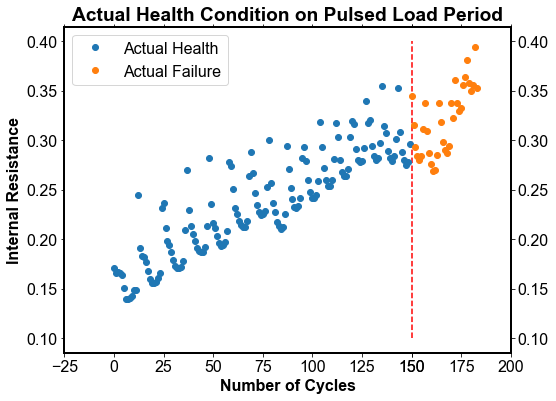

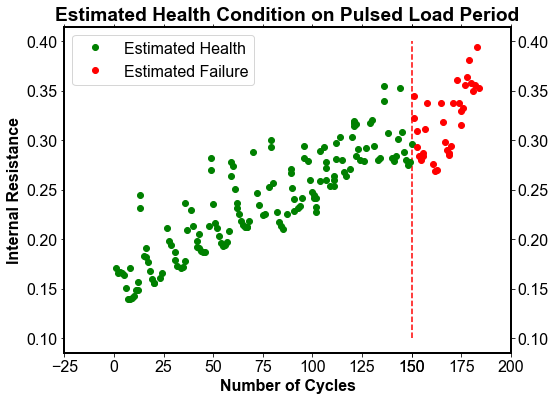

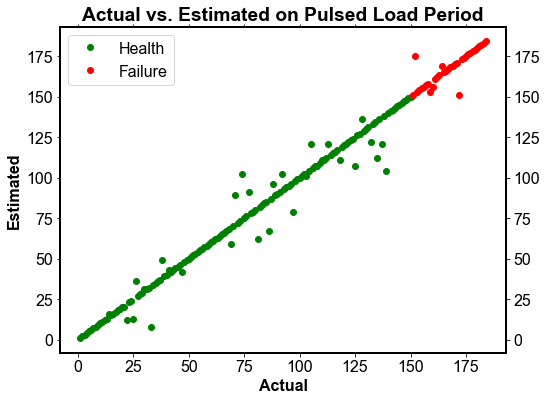

In [33]:
#Actual Data

plt.figure(figsize=(8, 6)) 

plt.plot(r[0:150].index,r[0:150],'o',label = 'Actual Health')
plt.plot(r[150:184].index,r[150:184],'o',label = 'Actual Failure')

plt.vlines(150,0.1,0.4, colors='red',linestyles='dashed')
plt.xticks(list(plt.xticks()[0]) + [150])
plt.legend()


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Internal Resistance',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Actual Health Condition on Pulsed Load Period',weight='bold')
plt.show()


# Predicted Data
y_pred = model.predict(soh_df[features_new].astype(float))
y_pred = np.round(y_pred)



plt.figure(figsize=(8, 6)) 

plt.plot(y_pred[0:150],r[0:150],'o',label = 'Estimated Health', c = 'green')
plt.plot(y_pred[150:184],r[150:184],'o',label = 'Estimated Failure', c = 'red')
plt.legend()

plt.vlines(150,0.1,0.4, colors='red',linestyles='dashed')
plt.xticks(list(plt.xticks()[0]) + [150])


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Internal Resistance',weight='bold')
plt.xlabel('Number of Cycles',weight='bold')
plt.title('Estimated Health Condition on Pulsed Load Period',weight='bold')
plt.show()

# Comparsion


plt.figure(figsize=(8, 6)) 

plt.plot(soh_df['cycle'][0:150],y_pred[0:150],'o',label = 'Health', c = 'green')
plt.plot(soh_df['cycle'][150:184],y_pred[150:184],'o',label = 'Failure', c = 'red')
plt.legend()


plt.rc('font', family='Arial')
plt.rc('font', size= 16)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.labelright'] = True
plt.rcParams['axes.linewidth'] = 2
plt.ylabel('Estimated',weight='bold')
plt.xlabel('Actual',weight='bold')
plt.title('Actual vs. Estimated on Pulsed Load Period',weight='bold')
plt.show()

## Cycle Prediciton Accuracy

In [34]:
# cycle prediciton accuracy
correct = 0
actual = list()
pred = list()
for i in range(len(soh_df)):
    if soh_df['predict'][i] == soh_df['cycle'][i]:
        correct += 1
    else:
        actual.append(soh_df['cycle'][i])
        pred.append(soh_df['predict'][i])
           
accuracy = correct/184
print('Accuracy for cycle prediction before modified is:',accuracy)

# if prediction error is within one cycle, roughly considered as correct

for i in range(len(soh_df)):
    if abs(soh_df['predict'][i] - soh_df['cycle'][i]) == 1:
        correct += 1
        
accuracy = correct/184
print('Accuracy for cycle prediction after modified is:',accuracy)


Accuracy for cycle prediction before modified is: 0.8043478260869565
Accuracy for cycle prediction after modified is: 0.8260869565217391


## Application Model on Real-time Input

In [35]:
from termcolor import colored, cprint


In [36]:
np.random.seed(7)

sample_data = soh_df.sample(n = 10)
sample_data = sample_data.reset_index(drop = True)

sample_x = sample_data[features_new].astype(float)
sample_y = sample_data['cycle']

sample_y_pred = np.round(model.predict(sample_x))

for i in range(len(sample_y_pred)):
    print('For the follwing input data on pulsed load period:')
    print(sample_x.iloc[i].to_string())
    print(colored('The estimated current cycle is at'), colored('No.','green'), colored(int(sample_y_pred[i]),'green'))
    if sample_y_pred[i] < 150:
        print(colored('There are estimated'), colored(150 - int(sample_y_pred[i]), 'blue'), colored('cycles left to reach failure threshold'))
    else: print(colored('There are estimated'), colored(int(sample_y_pred[i]) - 150,'red'), colored('cycles overused beyond failure threshold'))
    
    print('The actual No. cycle is: ', sample_y[i])
    print(colored('The actual current cycle is at'), colored('No.','green'), colored(int(sample_y[i]), 'green'))
    if int(sample_y[i]) < 150:
        print(colored('There are actual'), colored(150 - int(sample_y[i]), 'blue'), colored('cycles left to reach failure threshold'))
    else:
        print(colored('There are actual'), colored(int(sample_y[i]) - 150, 'red'), colored('cycles overused beyond failure threshold'))
    if sample_y_pred[i] == sample_y[i]:
        print(colored('Correct Estimation','yellow'))
    else:
        print(colored('Error Estimation', 'yellow'))
    print('-----------------------------------------------------------------------------------------')


For the follwing input data on pulsed load period:
current                 0.999902
voltage_ocv             3.768271
internal_resistance     0.394053
temperature            33.954746
soc                     0.029939
discharge_range         0.433000
The estimated current cycle is at No. 183
There are estimated 33 cycles overused beyond failure threshold
The actual No. cycle is:  183.0
The actual current cycle is at No. 183
There are actual 33 cycles overused beyond failure threshold
Correct Estimation
-----------------------------------------------------------------------------------------
For the follwing input data on pulsed load period:
current                 0.999900
voltage_ocv             4.029693
internal_resistance     0.357614
temperature            33.418471
soc                     0.380808
discharge_range         0.333000
The estimated current cycle is at No. 180
There are estimated 30 cycles overused beyond failure threshold
The actual No. cycle is:  180.0
The actual curren